# TextCNN Model On IMDB Dataset

___

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

import gensim.downloader as api

import re
import string
from collections import Counter

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


___

### NECESSARY FUNCTIONS

In [3]:
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [4]:
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [5]:
#!g1.1
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    train_accuracy = [x.cpu().numpy() if torch.is_tensor(x) else x for x in train_accuracy]
    valid_accuracy = [x.cpu().numpy() if torch.is_tensor(x) else x for x in valid_accuracy]

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        print(f'Valid accuracy on {epoch} = {valid_accuracy}')
        
        if valid_accuracy >= 0.87: 
            print("Reached 87% accuracy on validation set. Stopping training.")
            break
        
    print(f'Valid accuracy = {valid_accuracy}')

In [36]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model = model.to(device)
    model.eval()  # set the model to evaluation mode

    with torch.no_grad():  # deactivate autograd
        for x, _ in loader:  # we do not need 'y' for predictions
            x = x.to(device)
            output = model(x)  # forward pass
            preds = torch.sigmoid(output).squeeze()  # apply sigmoid and squeeze
            preds = (preds > 0.5).int()  # convert probabilities to class labels (0 or 1)
            predictions.append(preds)

    return torch.cat(predictions)


___

### DATASET

In [8]:
class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [9]:
df = pd.read_csv('/kaggle/input/imdb-dataset-nikitaefremove/IMDB Dataset.csv')

In [10]:
texts = df['review'].values
vocab = Vocabulary(texts, min_freq=5)

In [11]:
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, df, vocab):
        self.df = df

        self.vocab = vocab

        self.label2idx = {'positive': 0, 'negative': 1}

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [12]:
dataset = IMDB(df, vocab)

In [13]:
df_train, df_test = np.split(df, [45000], axis=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [14]:
train_dataset = IMDB(df_train, vocab)
test_dataset = IMDB(df_test, vocab)

In [15]:
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, pin_memory=True)

___

### BUILDING A MODEL

In [17]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(fs, embedding_dim)),
                nn.ReLU(),
                nn.BatchNorm2d(32)
            ) 
            for fs in [2, 3, 4, 5, 6, 7]
        ])

        self.fc = nn.Linear(6 * 32, 1)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

In [18]:
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [19]:
vectors = dataset.vocab.build_vectors(fasttext)

In [20]:
vectors.shape

(39273, 25)

In [21]:
model.embedding.weight.shape

torch.Size([39274, 25])

In [22]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [23]:
model.embedding.weight.shape

torch.Size([39274, 25])

In [24]:
import torch.nn as nn
from torch.optim import Adam

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cuda:0
Tesla T4


In [26]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

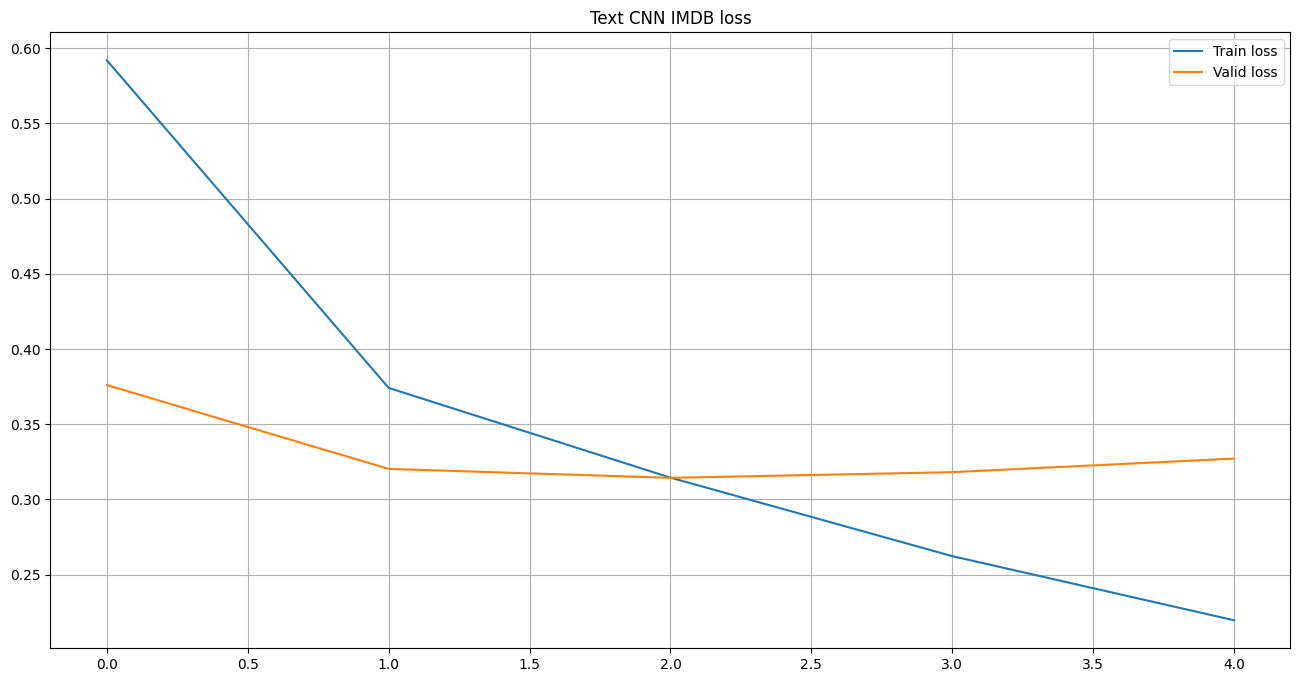

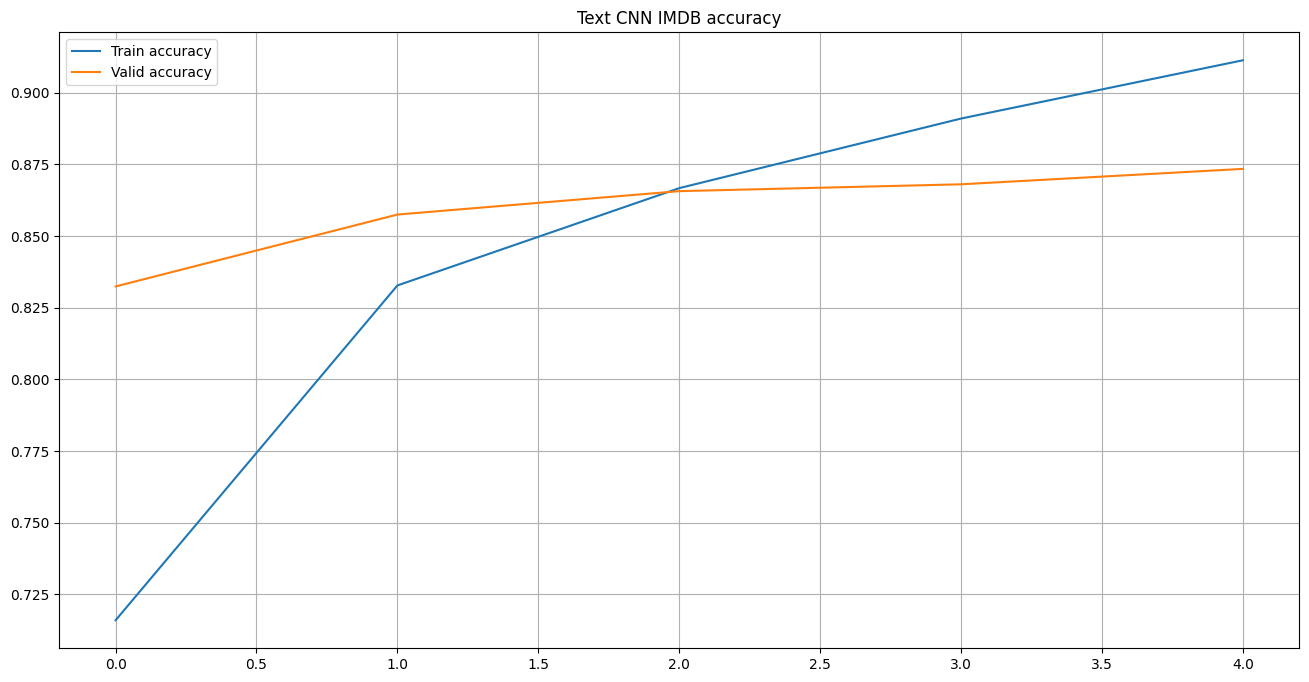

Valid accuracy on 4 = 0.8734076619148254
Reached 87% accuracy on validation set. Stopping training.
Valid accuracy = 0.8734076619148254


In [27]:
whole_train_valid_cycle(model, 100, 'Text CNN IMDB')

In [37]:
predictions = predict(model, test_loader, device)

In [38]:
torch.save(predictions, 'predictions.pt')